# IMDB Example

This example is based on an example from François Chollet's Deep Learning
with Python that was also made available in the
`3.5-classifying-movie-reviews.ipynb` notebook at

    https://github.com/fchollet/deep-learning-with-python-notebooks

In [1]:
!cd .. && pip install -e .

Obtaining file:///src/workspace/pybt
  Found existing installation: pybt 0.2.1
    Uninstalling pybt-0.2.1:
      Successfully uninstalled pybt-0.2.1
  Running setup.py develop for pybt


In [2]:
from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from keras import layers, models
from keras.datasets import imdb
from keras.layers import Dense
from keras.losses import binary_crossentropy
from keras.optimizers import RMSprop
from keras.utils import to_categorical

import numpy as np

from pybt import Trainer
from pybt.model import KerasModelWrapper
from pybt.policy.ready import ReadyAfter
from pybt.policy.done import StopAfter

Using TensorFlow backend.


In [4]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))

    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.

    return results

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

model = models.Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(lr=0.001),
              loss=binary_crossentropy,
              metrics=['accuracy'])

In [5]:
# Create a population with this model and train
m = KerasModelWrapper(model, optimizer=RMSprop(lr=0.001),
                      loss=binary_crossentropy,
                      metrics=['accuracy'])
t = Trainer(model=m,
    stopping_criteria=StopAfter(epochs=20),
    ready_strategy=ReadyAfter(4),
    step_args={'epochs_per_step': 2,
               'fit_args': {
                   'x': partial_x_train, 'y': partial_y_train,
                   'validation_data': (x_val, y_val),
                   'batch_size': 512}},
    eval_args={'x': x_val, 'y': y_val})
model, score = t.train()

10000/10000 [==============================] - 1s 106us/step
Train on 15000 samples, validate on 10000 samples
Epoch 1/2
15000/15000 [==============================] - 2s 123us/step - loss: 0.5229 - acc: 0.7865 - val_loss: 0.3981 - val_acc: 0.8709
Epoch 2/2
10000/10000 [==============================] - 1s 104us/step
Train on 15000 samples, validate on 10000 samples
Epoch 3/4
15000/15000 [==============================] - 2s 120us/step - loss: 0.2377 - acc: 0.9228 - val_loss: 0.3063 - val_acc: 0.8792
Epoch 4/4
10000/10000 [==============================] - 1s 109us/step
Train on 15000 samples, validate on 10000 samples
Epoch 3/4
15000/15000 [==============================] - 5s 308us/step - loss: 0.2261 - acc: 0.9343 - val_loss: 0.2923 - val_acc: 0.8882
Epoch 4/4
10000/10000 [==============================] - 1s 109us/step
Train on 15000 samples, validate on 10000 samples
Epoch 5/6
15000/15000 [==============================] - 5s 306us/step - loss: 0.1821 - acc: 0.9412 - val_loss: 0.2

15000/15000 [==============================] - 5s 336us/step - loss: 0.1309 - acc: 0.9563 - val_loss: 0.2777 - val_acc: 0.8930
Epoch 20/20
10000/10000 [==============================] - 1s 132us/step


## Plotting population results

In [6]:
from pybt.helpers import notebook

obs = t.observations()

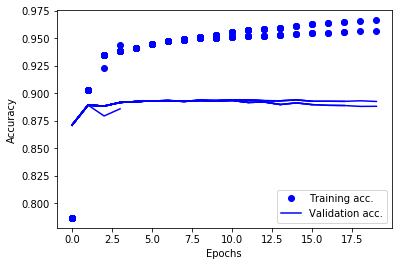

In [7]:
notebook.plot_members_acc(obs).show()

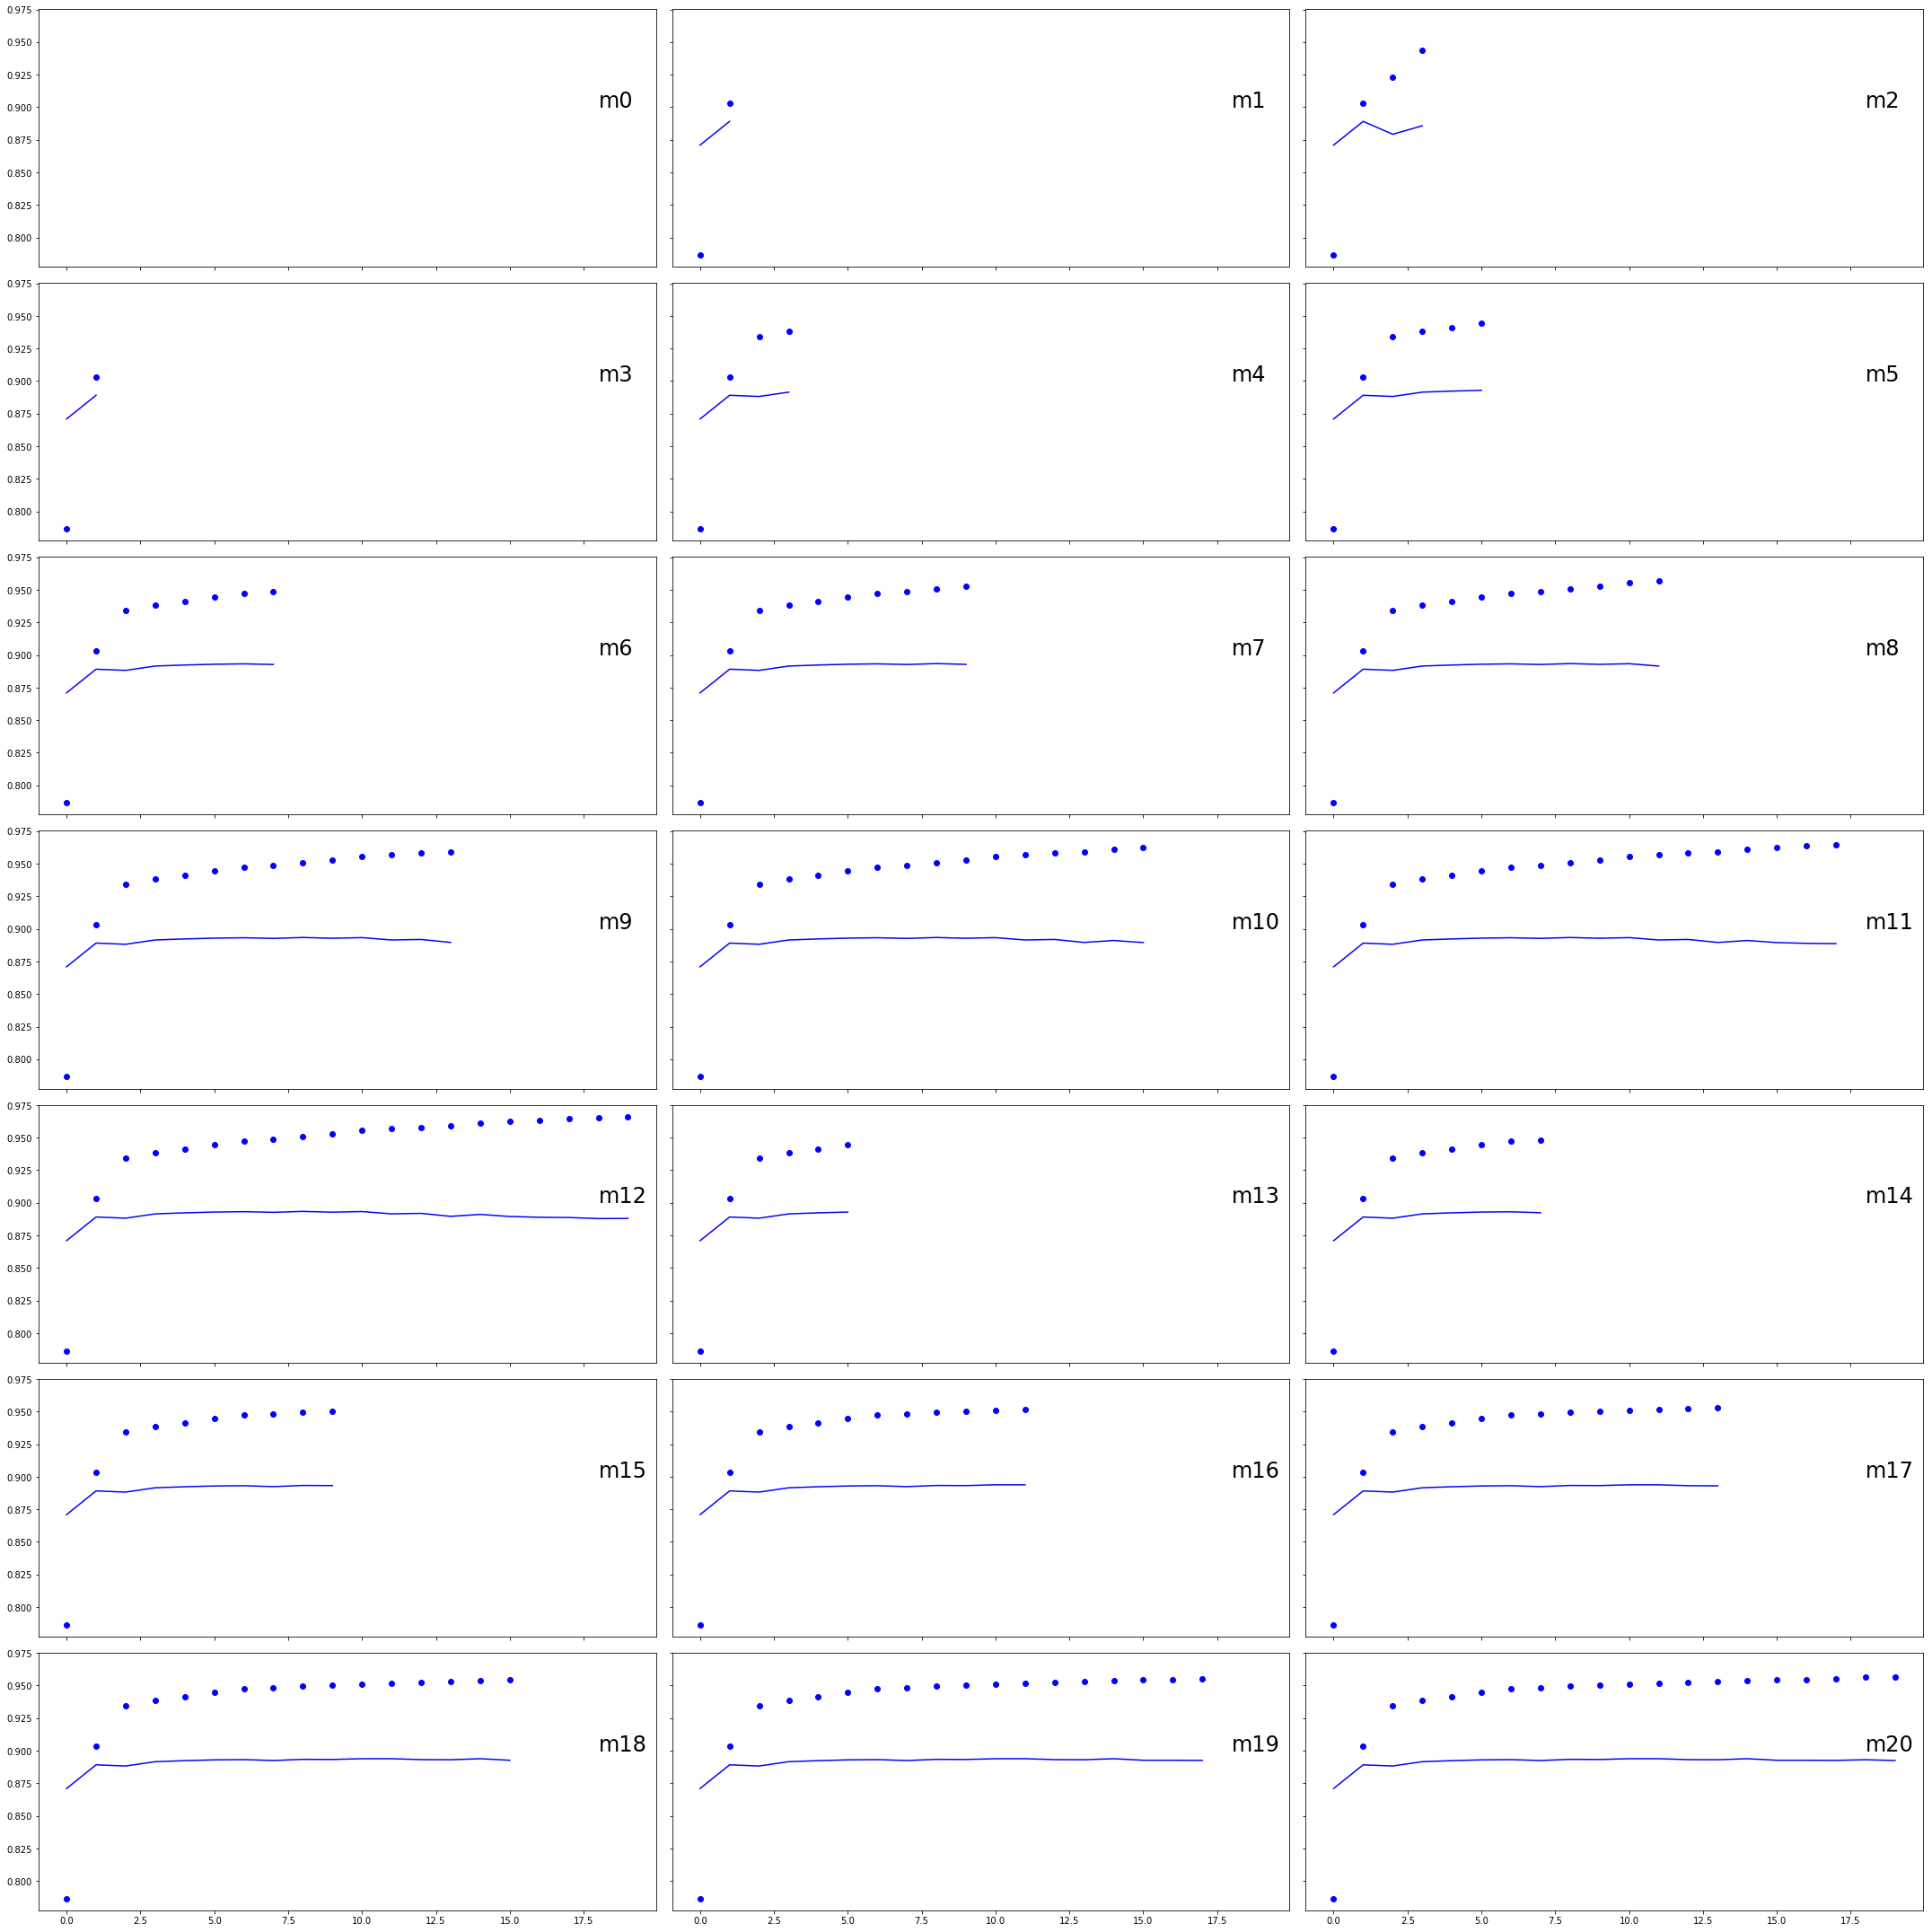

In [8]:
notebook.plot_all_acc(obs)

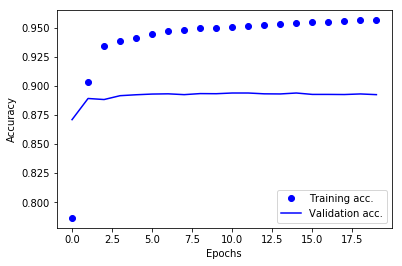

In [9]:
notebook.plot_member_acc(obs, 20).show()

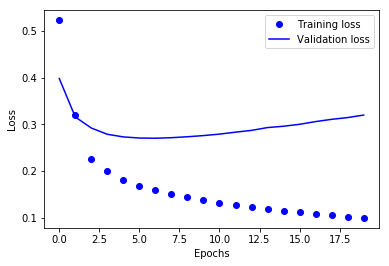

In [10]:
notebook.plot_member_loss(obs, 12).show()

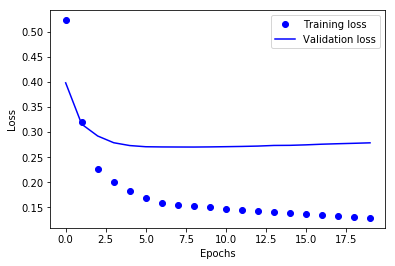

In [11]:
notebook.plot_member_loss(obs, 20).show()

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

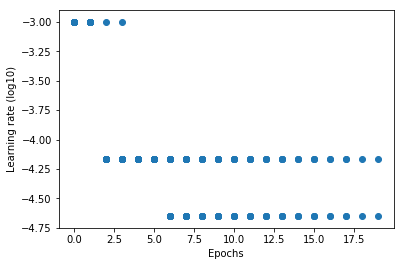

In [12]:
notebook.plot_learning_rate(obs)